In [98]:
from mnist.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.optimize import minimize
from matplotlib import rcParams
from sklearn import linear_model

mndata = MNIST('/Users/zhaoheng/Downloads/mnist')
train_X, train_y = mndata.load_training()
test_X, test_y = mndata.load_testing()
#shape of dataset
print('X_train: ' + str(np.shape(train_X)))
print('Y_train: ' + str(np.shape(train_y)))
print('X_test:  '  + str(np.shape(test_X)))
print('Y_test:  '  + str(np.shape(test_y)))
train_X_img = np.reshape(train_X, (60000,28,28))
test_X_img = np.reshape(test_X, (10000,28,28))


X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


## (a) SVD analysis

In [2]:
U, S, VT = np.linalg.svd(train_X, full_matrices=False)
Ut, St, VTt = np.linalg.svd(test_X, full_matrices=False)

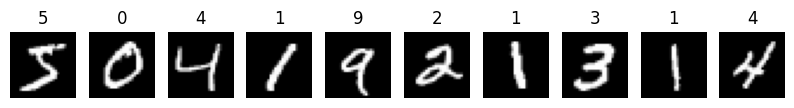

In [3]:
#show sample  digit images with label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_X_img[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(str(train_y[i]))
plt.show()

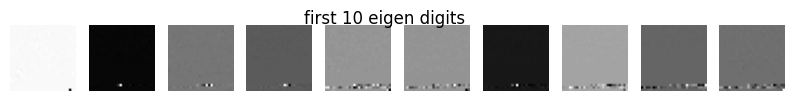

In [4]:
#show first 10 eigen digits 
plt.figure(figsize=(10,1))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.reshape(U[i],(28,28)), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.suptitle('first 10 eigen digits')
plt.show()

## (b) singular value spectrum and image reconstruction

Text(0.5, 1.0, 'Singular value spectrum S')

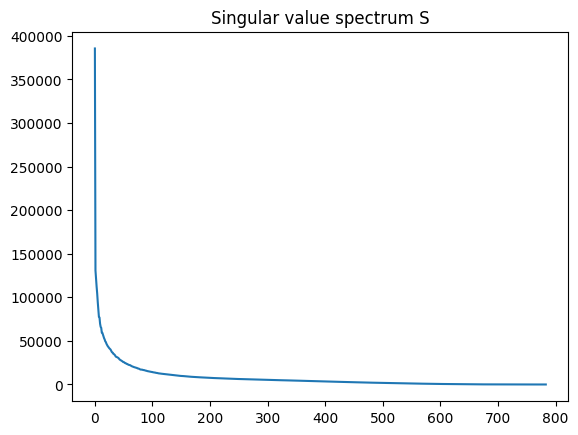

In [5]:
#plot singular value of SVD
plt.plot(S)
plt.title('Singular value spectrum S')

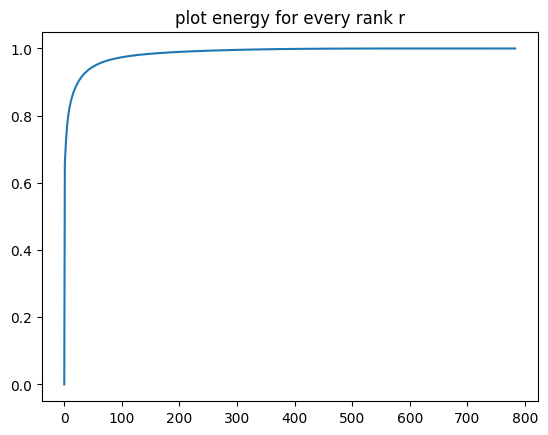

where rank r capture 0.90 energy: [25]
where rank r capture 0.99 energy: [202]
where rank r capture 0.999 energy: [416]


In [6]:
energy = [0.9, 0.99, 0.999]
energy_all = np.zeros(784)
for r in range(784):
    energy_all[r] = np.linalg.norm(S[:r])/np.linalg.norm(S)
plt.plot(energy_all)
plt.title('plot energy for every rank r')
plt.show()
print('where rank r capture 0.90 energy:', np.argwhere(energy_all>0.90)[0])
print('where rank r capture 0.99 energy:', np.argwhere(energy_all>0.99)[0])
print('where rank r capture 0.999 energy:', np.argwhere(energy_all>0.999)[0])

(60000, 784)


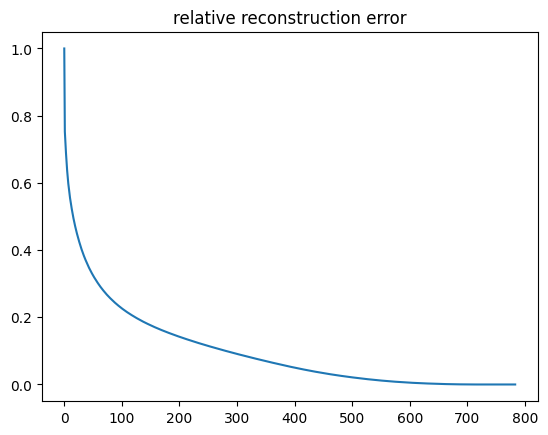

In [47]:
print(np.shape(train_X))
m = np.shape(train_X)[1]
rec_err = np.zeros(m)
S = np.diag(S)
for r in range(m):
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
    rec_err[r] = np.linalg.norm(Xapprox-train_X, 'fro')
#relative reconstruction error
rela_err = rec_err/np.linalg.norm(train_X, 'fro')
plt.plot(rela_err)
plt.title('relative reconstruction error')
plt.show()

## (d) project onto 3 selected V modes

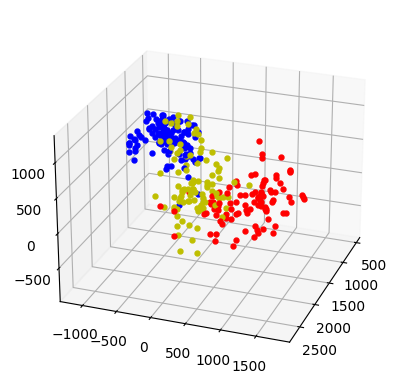

In [92]:
#project onto 3 modes(columns) 1st 2nd and 3rd column of V
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection = '3d')

for j in range(1000):
    #print(j)
    x = VT[0,:] @ np.transpose(train_X[j])
    y = VT[1,:] @ np.transpose(train_X[j])
    z = VT[2,:] @ np.transpose(train_X[j])
    
    if train_y[j] == 0:
        #print('0')
        ax.scatter(x,y,z,marker='.',color='r',s=50)
    elif train_y[j] == 1:
        #print('1')
        ax.scatter(x,y,z,marker='.',color='b',s=50)
    elif train_y[j] == 2:
        #print('1')
        ax.scatter(x,y,z,marker='.',color='y',s=50)
    
    
ax.view_init(25,20)
plt.show()

by project onto first 3 modes of V, we observe that digits 0,1,2 are easily separated

In [3]:
r = 10
pca = np.zeros((r,60000))
pca_test = np.zeros((r,10000))
for i in range(r):
    pca[i,:] = VT[i,:] @ np.transpose(train_X)
for j in range(r):
    pca_test[j,:] = VT[j,:] @ np.transpose(test_X)
pca = np.transpose(pca)
pca_test = np.transpose(pca_test)

## (e) pick two digits, build LDA classifier

pick two digits

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
index01 = np.append(np.where(np.array(train_y)==0)[0], np.where(np.array(train_y)==1)[0])
train01_X = np.take(train_X, index01, axis=0)
train01_y = np.take(train_y, index01, axis=0)
index01_test = np.append(np.where(np.array(test_y)==0)[0], np.where(np.array(test_y)==1)[0])
test01_X = np.take(test_X, index01_test, axis=0)
test01_y = np.take(test_y, index01_test, axis=0)

build LDA classifier

In [115]:
lda = LinearDiscriminantAnalysis()
test01_class = lda.fit(train01_X, train01_y).predict(test01_X)

show confusion matrix of 0, 1 classification by LDA

accuracy of prediction by LDA of 0 and 1: 0.9938534278959811


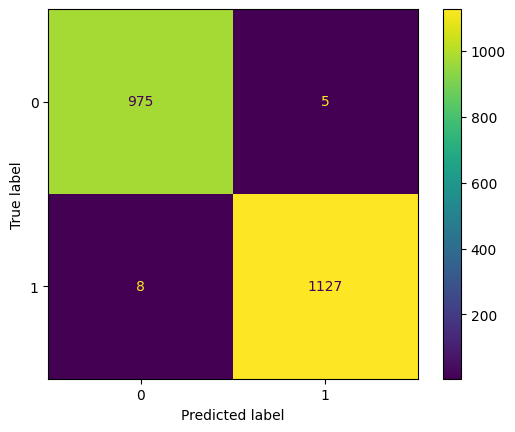

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm01_lda = confusion_matrix(test01_y, test01_class)
cm_display = ConfusionMatrixDisplay(cm01_lda).plot()
print('accuracy of prediction by LDA of 0 and 1:', np.count_nonzero(test01_y==test01_class)/len(test01_y))

the results of 01 classification looks perfect.

### LAD classification on whole data by pca reducted features

In [123]:

lda = LinearDiscriminantAnalysis()
test_class = lda.fit(pca, train_y).predict(pca_test)

accuracy of prediction by SVM: 0.7704


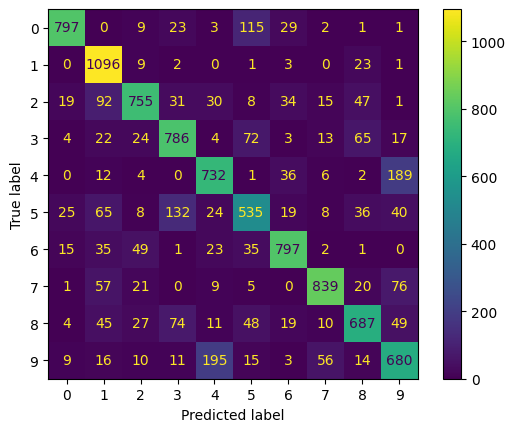

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, test_class)
cm_display = ConfusionMatrixDisplay(cm).plot()
print('accuracy of prediction by SVM:', np.count_nonzero(test_y==test_class)/10000)

## (i) SVM and Desicion tree classifier

### SVM classification

In [15]:
#svm classifier
from sklearn import svm, metrics
svmC = svm.SVC(kernel = 'linear', gamma = 0.001)
svmC.fit(pca, train_y)
predicted = svmC.predict(pca_test)


accuracy of prediction by SVM: 0.8424


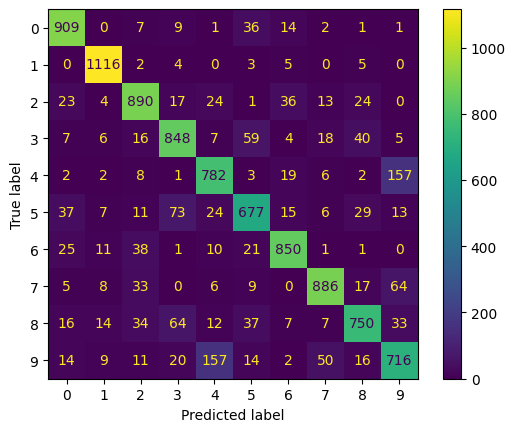

In [86]:
#print(np.count_nonzero(test_y==predicted))
cm_svm = confusion_matrix(test_y, predicted)
cm_display = ConfusionMatrixDisplay(cm_svm).plot()
print('accuracy of prediction by SVM:', np.count_nonzero(test_y==predicted)/10000)

Classification by SVM, digits 4 and 9 are not easy to classify, may be due to the similar shape.

In [ ]:
index01 = np.append(np.where(train_y==0)[0], np.where(train_y==1)[0])
train01_X = np.take(train_X, index01, axis=0)
train01_y = np.take(train_y, index01, axis=0)

### Decision tree classification

In [87]:
from sklearn import tree, preprocessing
cls_tree = tree.DecisionTreeClassifier(max_depth=10, random_state=True)
cls_tree.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=10, random_state=True)

accuracy of prediction by SVM: 0.8653


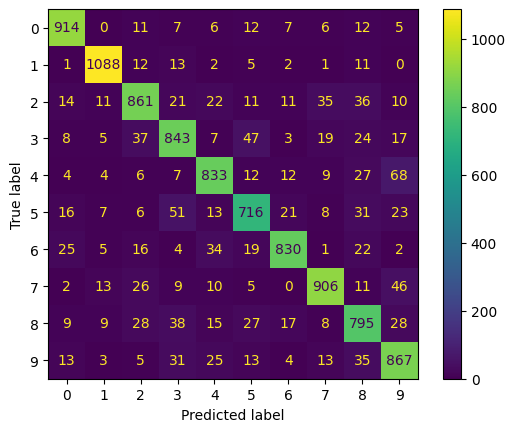

In [90]:
pred_tree = cls_tree.predict(test_X)
cm_tree = confusion_matrix(test_y, pred_tree)
cm_display = ConfusionMatrixDisplay(cm_tree).plot()
print('accuracy of prediction by decision tree:', np.count_nonzero(test_y==pred_tree)/10000)

classification by decision tree, results are better than SVM

In [125]:
index49 = np.append(np.where(np.array(train_y)==4)[0], np.where(np.array(train_y)==9)[0])
train49_X = np.take(train_X, index49, axis=0)
train49_y = np.take(train_y, index49, axis=0)
index49_test = np.append(np.where(np.array(test_y)==4)[0], np.where(np.array(test_y)==9)[0])
test49_X = np.take(test_X, index49_test, axis=0)
test49_y = np.take(test_y, index49_test, axis=0)

In [126]:
#svm classifier of 4 and 9
from sklearn import svm, metrics
svmC = svm.SVC(kernel = 'linear', gamma = 0.001)
svmC.fit(train49_X, train49_y)
predicted49 = svmC.predict(test49_X)

pred49_svm = cls_tree.predict(test49_X)
cm49_svm = confusion_matrix(test49_y, pred49_svm)
cm_display = ConfusionMatrixDisplay(cm49_svm).plot()
print('accuracy of prediction4 and 9 by svm:', np.count_nonzero(test49_y==pred49_svm)/len(test49_y))